In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# set up arrays
dx = 1000
x = np.arange(0, 100000, dx)
x_node = x + (dx/2)

Hstar = 0.5
etab = np.zeros(len(x)) # bedrock elevation, m
etab[:] = np.linspace(10, 0.1, len(x)) # need to start with slight bedrock slope
H = Hstar + np.zeros(len(x))
eta = etab + H

In [3]:
# set up parameters
# K_ig = np.zeros(len(x))
# K_ig[:24] = 1e-7
# K_sed = np.zeros(len(x))
# K_sed[24:] = 1e-6
K = np.zeros(len(x))
K[:] = 1e-7

# beta_ig = np.zeros(len(x))
# beta_ig[:24] = 4e-7
# beta_sed = np.zeros(len(x))
# beta_sed[24:] = 4e-6
beta = np.zeros(len(x))
beta[:] = 1e-5

# psi = np.zeros(len(x))
# psi[:14] = 4e-7
# psi[14:] = 4e-6
psi = 4e-5
gamma = 0.3

r = 10. # runoff rate
D = 0.015 # grain size
phi = 0.45 # porosity
baselevel_rate = 0.0001 # baselevel fall rate

In [4]:
kqs = 0.041
I = 0.01
kxb = 25
Pxb = 1./5.
kb = 8.3e-8

B_valley = kxb * (x_node**Pxb)
B_basin = (2./3.) * x_node

area = (1./3.) * x**2
# Q = r * x * B
Q = r * area

In [5]:
def model(x, dx, x_node,
          K, beta,
          D, phi, Hstar, psi, gamma,
          kb, kqs, I, r, B_valley, B_basin, Q,
          etab, H, eta,
          baselevel_rate,
          num_steps = 1):
    
    q = Q/B_valley
    # dt = 0.2 * dx * dx / (kqs * q[-1]) # try changing to 10, 5, or 1 if this is unstable
    dt = 5
    
    run_duration = dt * num_steps
    cum_time = 0.0
    
    Qs = np.zeros(len(x))
    qs = np.zeros(len(x))
    Eb_p = np.zeros(len(x))
    Eb_a = np.zeros(len(x))
    Eb = np.zeros(len(x))
    Eh = np.zeros(len(x))
    E = np.zeros(len(x))
    ql = np.zeros(len(x))
    
    H[-1] = 0
    E[-1] = baselevel_rate
    q[0] = 0
    Qs[0] = 0
    ql[0] = 0
    
    while cum_time < run_duration:
        
        # drop baselevel
        eta[-1] -= baselevel_rate * dt
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        
        # calc bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calc Rh
#         width = (kb * Q[1:] * (S ** (7/6))) / (D**(3/2))
#         depth = (0.09801 * D) / S
#         Rh_efficiency = 1 - np.exp(-width/(2*depth))
        
        # calc sed transport
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.) * (1 - alpha[:-1]) # * Rh_efficiency
        qs[1:] = Qs[1:] / B_valley[1:]
        
        # calc bedrock erosion
        Eb_p[:-1] = K[1:] * Q[1:] * S * alpha[:-1]
        Eb_a[:-1] = beta[1:] * Qs[1:] * alpha[:-1]
        Eb[:-1] = (Eb_p[:-1] + Eb_a[:-1]) / B_valley[:-1]
        
        # calc grain attrition
        atr = Qs * psi
        
        # calc equilibrium lateral supply
        ql[1:] = ((baselevel_rate * gamma) / psi) * (1 - np.exp(-psi/(3 * x[1:])))
        # ql[24:] = 0
        
        # calc sediment erosion rate
        Eh[:-1] = 1/((1 - phi) * B_valley[:-1]) * (np.diff(Qs)/dx + atr[1:] - Eb_p[:-1] - ql[1:])
        
        # calc total erosion rate
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] -= Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
        # update elapsed time
        cum_time += dt
        
    print(cum_time)
        
    return (dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, atr, ql, Eh, E, etab, H, eta)

In [6]:
#now write a test
num_steps = 5000000
test_run = [x, dx, x_node, 
            K, beta, 
            D, phi, Hstar, psi, gamma,
            kb, kqs, I, r, B_valley, B_basin, Q,
            etab, H, eta,
            baselevel_rate,
            num_steps]

# and run it
(dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, atr, ql, Eh, E, etab, H, eta) = model(*test_run)

25000000.0


In [7]:
E

array([1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04])

In [8]:
# now make nice slope area figure

In [9]:
m, b = np.polyfit(np.log(area[1:]), np.log(S), 1)
# m_up, b_up = np.polyfit(np.log(area[1:25]), np.log(S[:24]), 1)
# m_down, b_down = np.polyfit(np.log(area[25:]), np.log(S[24:]), 1)

slope_fit = np.exp((m * np.log(area[1:])) + b)
# slope_fit_up = np.exp((m_up * np.log(area[1:25])) + b_up)
# slope_fit_down = np.exp((m_down * np.log(area[25:])) + b_down)

In [10]:
# upper_bound_up_m = m_up + 0.07
# lower_bound_up_m = m_up - 0.07

# upper_bound_down_m = m_down + 0.07
# lower_bound_down_m = m_down - 0.07

upper_bound_total_m = m + 0.05
lower_bound_total_m = m - 0.05

In [11]:
# upper_bound_up_slope_fit = np.exp((upper_bound_up_m * np.log(area[1:25])) + b_up)
# lower_bound_up_slope_fit = np.exp((lower_bound_up_m * np.log(area[1:25])) + b_up)

# upper_bound_down_slope_fit = np.exp((upper_bound_down_m * np.log(area[25:])) + b_down)
# lower_bound_down_slope_fit = np.exp((lower_bound_down_m * np.log(area[25:])) + b_down)

upper_bound_total_slope_fit = np.exp((upper_bound_total_m * np.log(area[1:])) + b)
lower_bound_total_slope_fit = np.exp((lower_bound_total_m * np.log(area[1:])) + b)

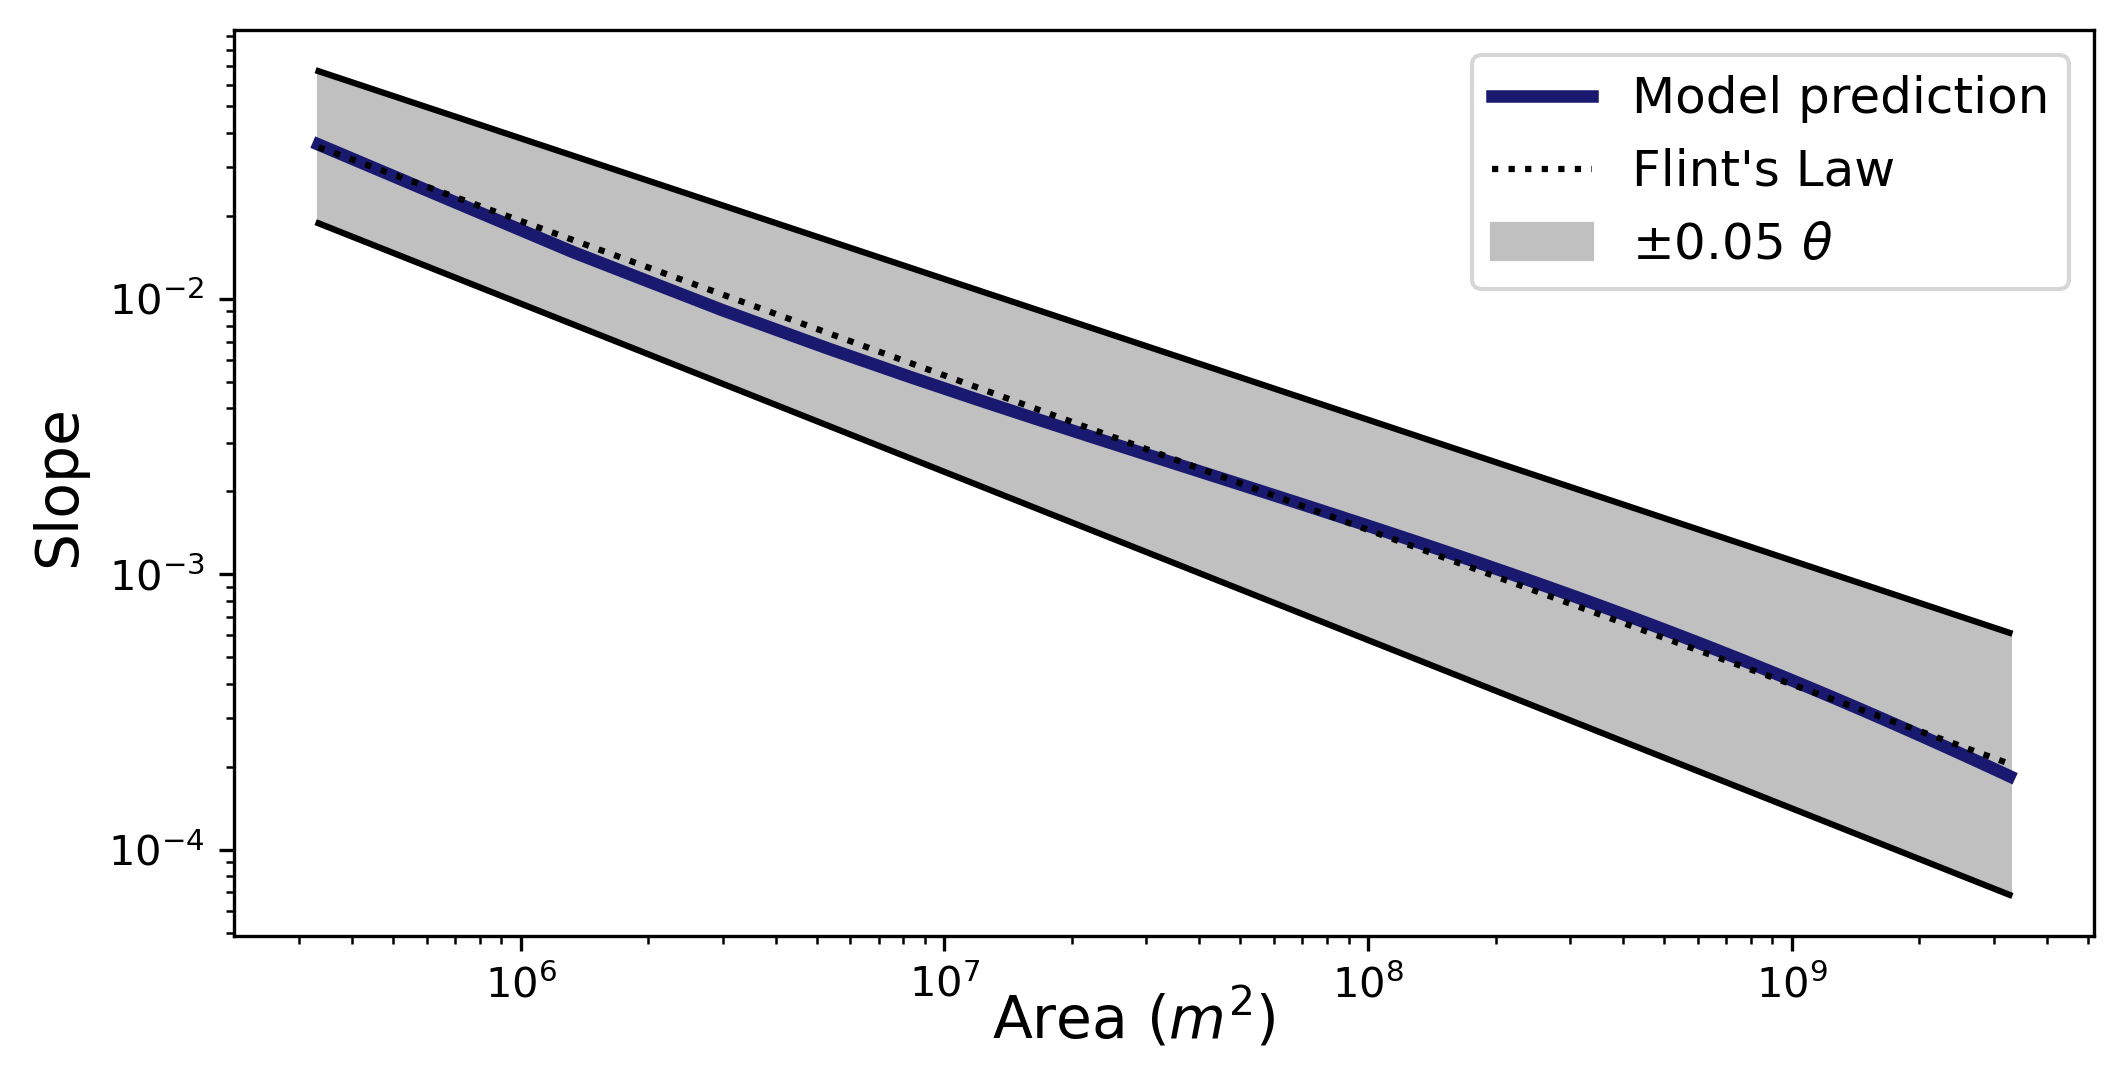

In [15]:
# what if I made the above just one figure?
plt.rcParams['figure.dpi'] = 300
# plt.rcParams['savefig.dpi'] = 300

fig, ax = plt.subplots(1, figsize = (8, 4), sharex = True, sharey = True)
fig.text(0.04, 0.5, 'Slope', va='center', rotation='vertical', fontsize = 14)
fig.text(0.5, 0.04, 'Area $(m^2)$', ha='center', fontsize = 14)
# fig.suptitle('Slope-area relationships', fontsize = 16)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.2)

ax.plot(area[1:], S[:], color = 'midnightblue', linewidth = 3, label = 'Model prediction')
ax.plot(area[1:], slope_fit, color = 'k',linestyle = ':', label = "Flint's Law")
ax.plot(area[1:], upper_bound_total_slope_fit, color = 'k')
ax.plot(area[1:], lower_bound_total_slope_fit, color = 'k')
ax.fill_between(area[1:], upper_bound_total_slope_fit, lower_bound_total_slope_fit, color = 'silver', alpha = 1.0, label = '$\pm 0.05\ \\theta$')
# ax.fill_between(area[25:], upper_bound_down_slope_fit, lower_bound_down_slope_fit, color = 'k', alpha = 0.2)
ax.set_yscale('log')
ax.set_xscale('log')
# ax.vlines(area[24:25], 0.1, 0.00001, linestyle = '--', color = 'k', label = 'Bedrock contact')
# axs[0].set_title('Upstream', fontsize = 16)
ax.legend(loc = 'best', fontsize = 12)

# ax.plot(area[25:], S[24:], color = 'darkgreen', linewidth = 3)
# ax.plot(area[25:], slope_fit_down, color = 'k',linestyle = ':')
# ax.plot(area[25:], upper_bound_down_slope_fit, color = 'k')
# ax.plot(area[25:], lower_bound_down_slope_fit, color = 'k')
# # ax.fill_between(area[1:25], upper_bound_up_slope_fit, lower_bound_up_slope_fit, color = 'k', alpha = 0.2)
# ax.fill_between(area[25:], upper_bound_down_slope_fit, lower_bound_down_slope_fit, color = 'darkgreen', alpha = 0.2)
# ax.set_yscale('log')
# ax.set_xscale('log')
# # axs[1].set_title('Downstream', fontsize = 16)

plt.savefig('AGU_SA_plot_single.png')
plt.show()

In [16]:
# # what if I made the above just one figure?
# plt.rcParams['figure.dpi'] = 300
# # plt.rcParams['savefig.dpi'] = 300

# fig, ax = plt.subplots(1, figsize = (10, 4), sharex = True, sharey = True)
# fig.text(0.04, 0.5, 'Slope', va='center', rotation='vertical', fontsize = 14)
# fig.text(0.5, 0.04, 'Area $(m^2)$', ha='center', fontsize = 14)
# # fig.suptitle('Slope-area relationships', fontsize = 16)
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.2)

# ax.plot(area[1:25], S[:24], color = 'darkgreen', linewidth = 3, label = 'Model prediction')
# ax.plot(area[1:25], slope_fit_up, color = 'k',linestyle = ':', label = "Flint's Law")
# ax.plot(area[1:25], upper_bound_up_slope_fit, color = 'k')
# ax.plot(area[1:25], lower_bound_up_slope_fit, color = 'k')
# ax.fill_between(area[1:25], upper_bound_up_slope_fit, lower_bound_up_slope_fit, color = 'darkgreen', alpha = 0.2, label = 'Field data scatter')
# # ax.fill_between(area[25:], upper_bound_down_slope_fit, lower_bound_down_slope_fit, color = 'k', alpha = 0.2)
# ax.set_yscale('log')
# ax.set_xscale('log')
# ax.vlines(area[24:25], 0.1, 0.00001, linestyle = '--', color = 'k', label = 'Bedrock contact')
# # axs[0].set_title('Upstream', fontsize = 16)
# ax.legend(loc = 'best', fontsize = 12)

# ax.plot(area[25:], S[24:], color = 'darkgreen', linewidth = 3)
# ax.plot(area[25:], slope_fit_down, color = 'k',linestyle = ':')
# ax.plot(area[25:], upper_bound_down_slope_fit, color = 'k')
# ax.plot(area[25:], lower_bound_down_slope_fit, color = 'k')
# # ax.fill_between(area[1:25], upper_bound_up_slope_fit, lower_bound_up_slope_fit, color = 'k', alpha = 0.2)
# ax.fill_between(area[25:], upper_bound_down_slope_fit, lower_bound_down_slope_fit, color = 'darkgreen', alpha = 0.2)
# ax.set_yscale('log')
# ax.set_xscale('log')
# # axs[1].set_title('Downstream', fontsize = 16)

# # plt.savefig('AGU_SA_plot.png')
# plt.show()

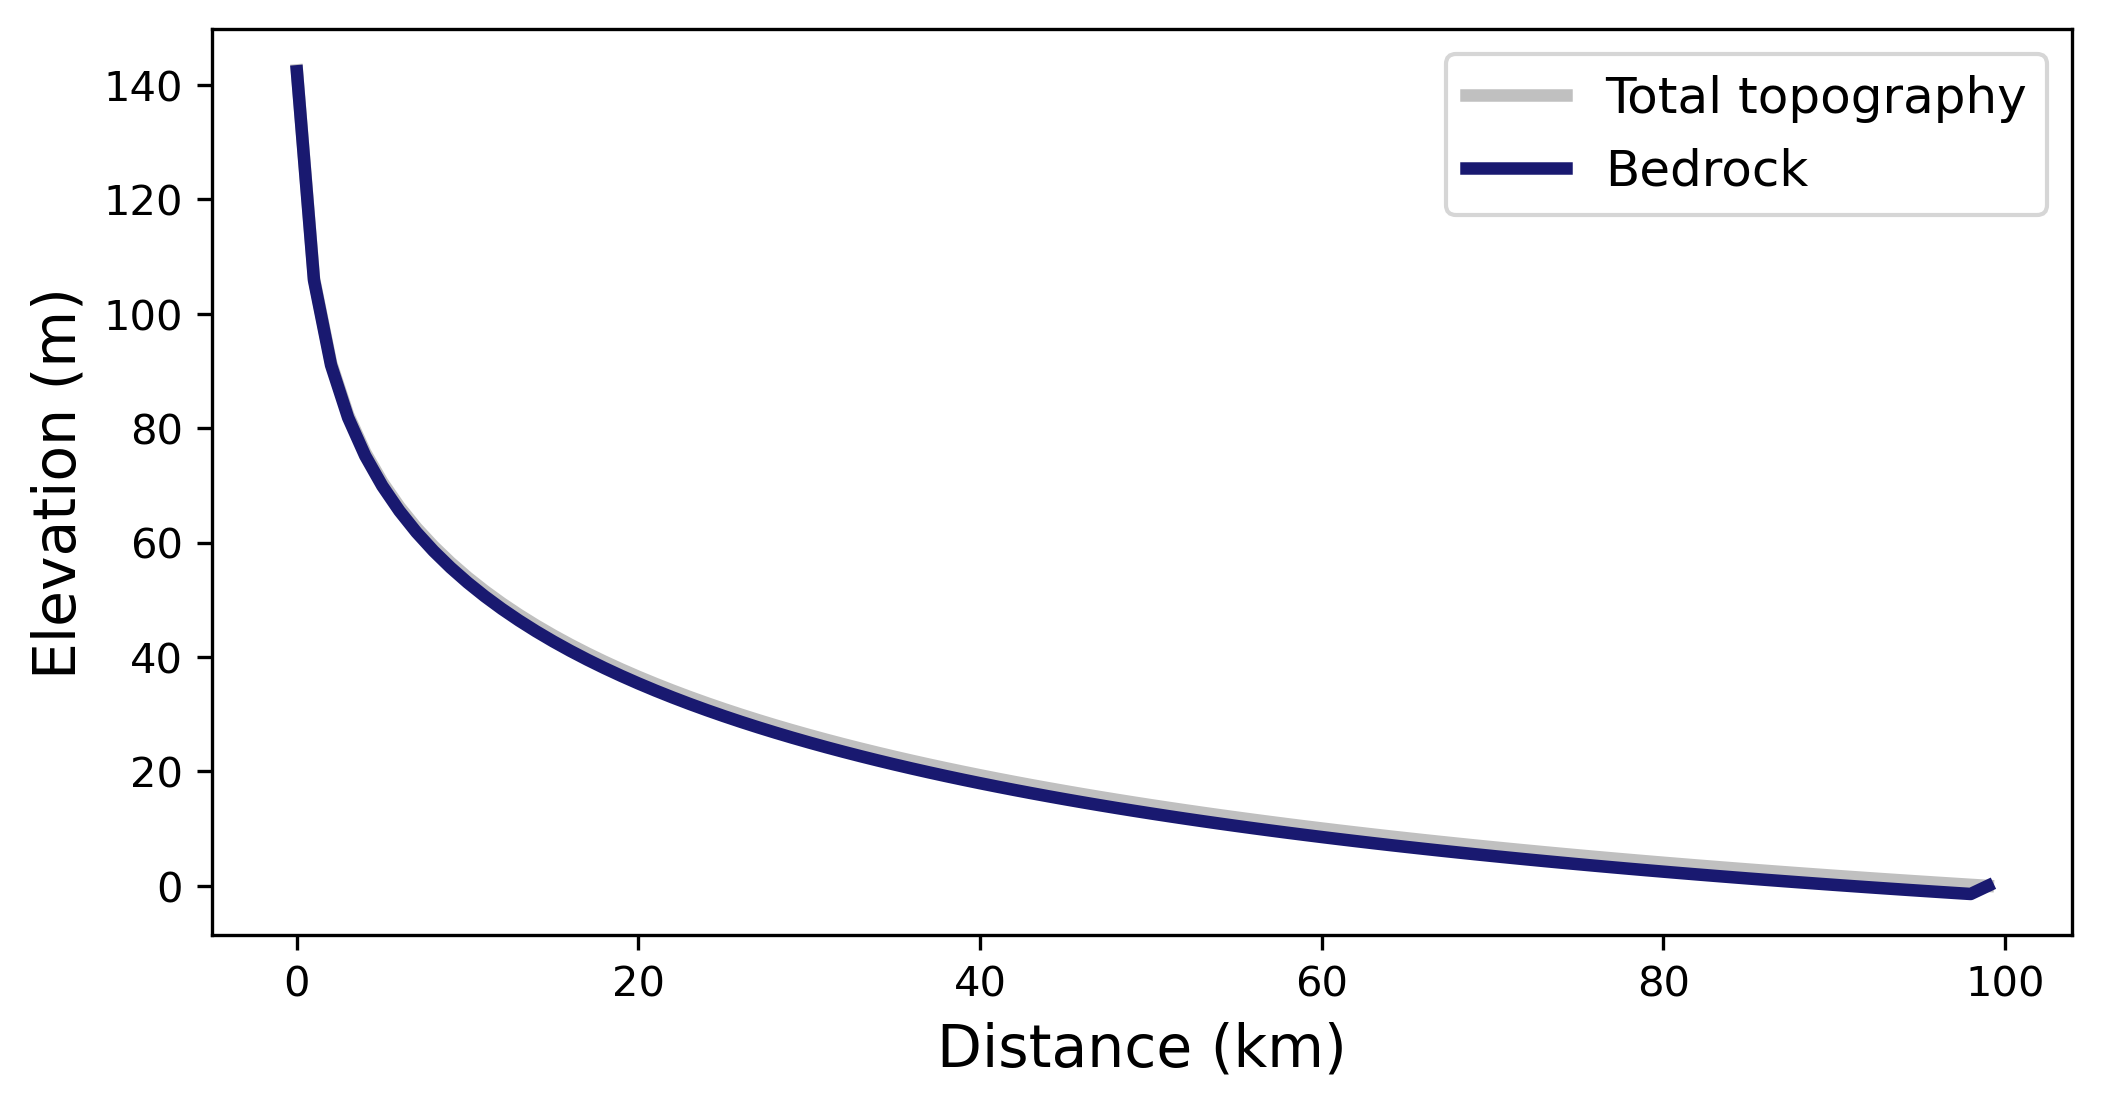

In [17]:
# great, now make a steady state profile figure
plt.rcParams['figure.dpi'] = 300
# plt.rcParams['savefig.dpi'] = 300

fig = plt.figure(figsize = (8, 4))

plt.plot(x/1000, eta - eta[-1], label = 'Total topography', color = 'silver', linewidth = 3)
plt.plot(x/1000, etab - eta[-1], label = 'Bedrock', color = 'midnightblue', linewidth = 3)
plt.xlabel('Distance (km)', fontsize = 14)
plt.ylabel('Elevation (m)', fontsize = 14)
# plt.vlines(x = 24, 
#            ymin = 0, 
#            ymax = 160, 
#            label = 'Bedrock contact', 
#            color = 'k', 
#            linestyle = '--')
# plt.title('Steady state topography', fontsize = 16)
plt.legend(fontsize = 12)

plt.savefig('AGU_concavity_plot_single.png')
plt.show()

In [18]:
# Now set up to test higher uplift rate

# set up arrays
dx_2 = 1000
x_2 = np.arange(0, 100000, dx_2)
x_node_2 = x_2 + (dx_2/2)

Hstar_2 = 0.5
etab_2 = np.zeros(len(x_2)) # bedrock elevation, m
etab_2[:] = np.linspace(10, 0.1, len(x_2)) # need to start with slight bedrock slope
H_2 = Hstar_2 + np.zeros(len(x_2))
eta_2 = etab_2 + H_2

In [19]:
#now write a test
num_steps_2 = 5000000
test_run_2 = [x_2, dx_2, x_node_2, 
            K, beta, 
            D, phi, Hstar_2, psi, gamma,
            kb, kqs, I, r, B_valley, B_basin, Q,
            etab_2, H_2, eta_2,
            baselevel_rate * 3,
            num_steps_2]

# and run it
(dt_2, S_2, q_2, alpha_2, Qs_2, qs_2, Eb_p_2, Eb_a_2, Eb_2, atr_2, ql_2, Eh_2, E_2, etab_2, H_2, eta_2) = model(*test_run_2)

25000000.0


In [20]:
E_2

array([0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
       0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
       0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
       0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
       0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
       0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
       0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
       0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
       0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
       0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
       0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
       0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
       0.0003, 0.0003, 0.0003, 0.0003])

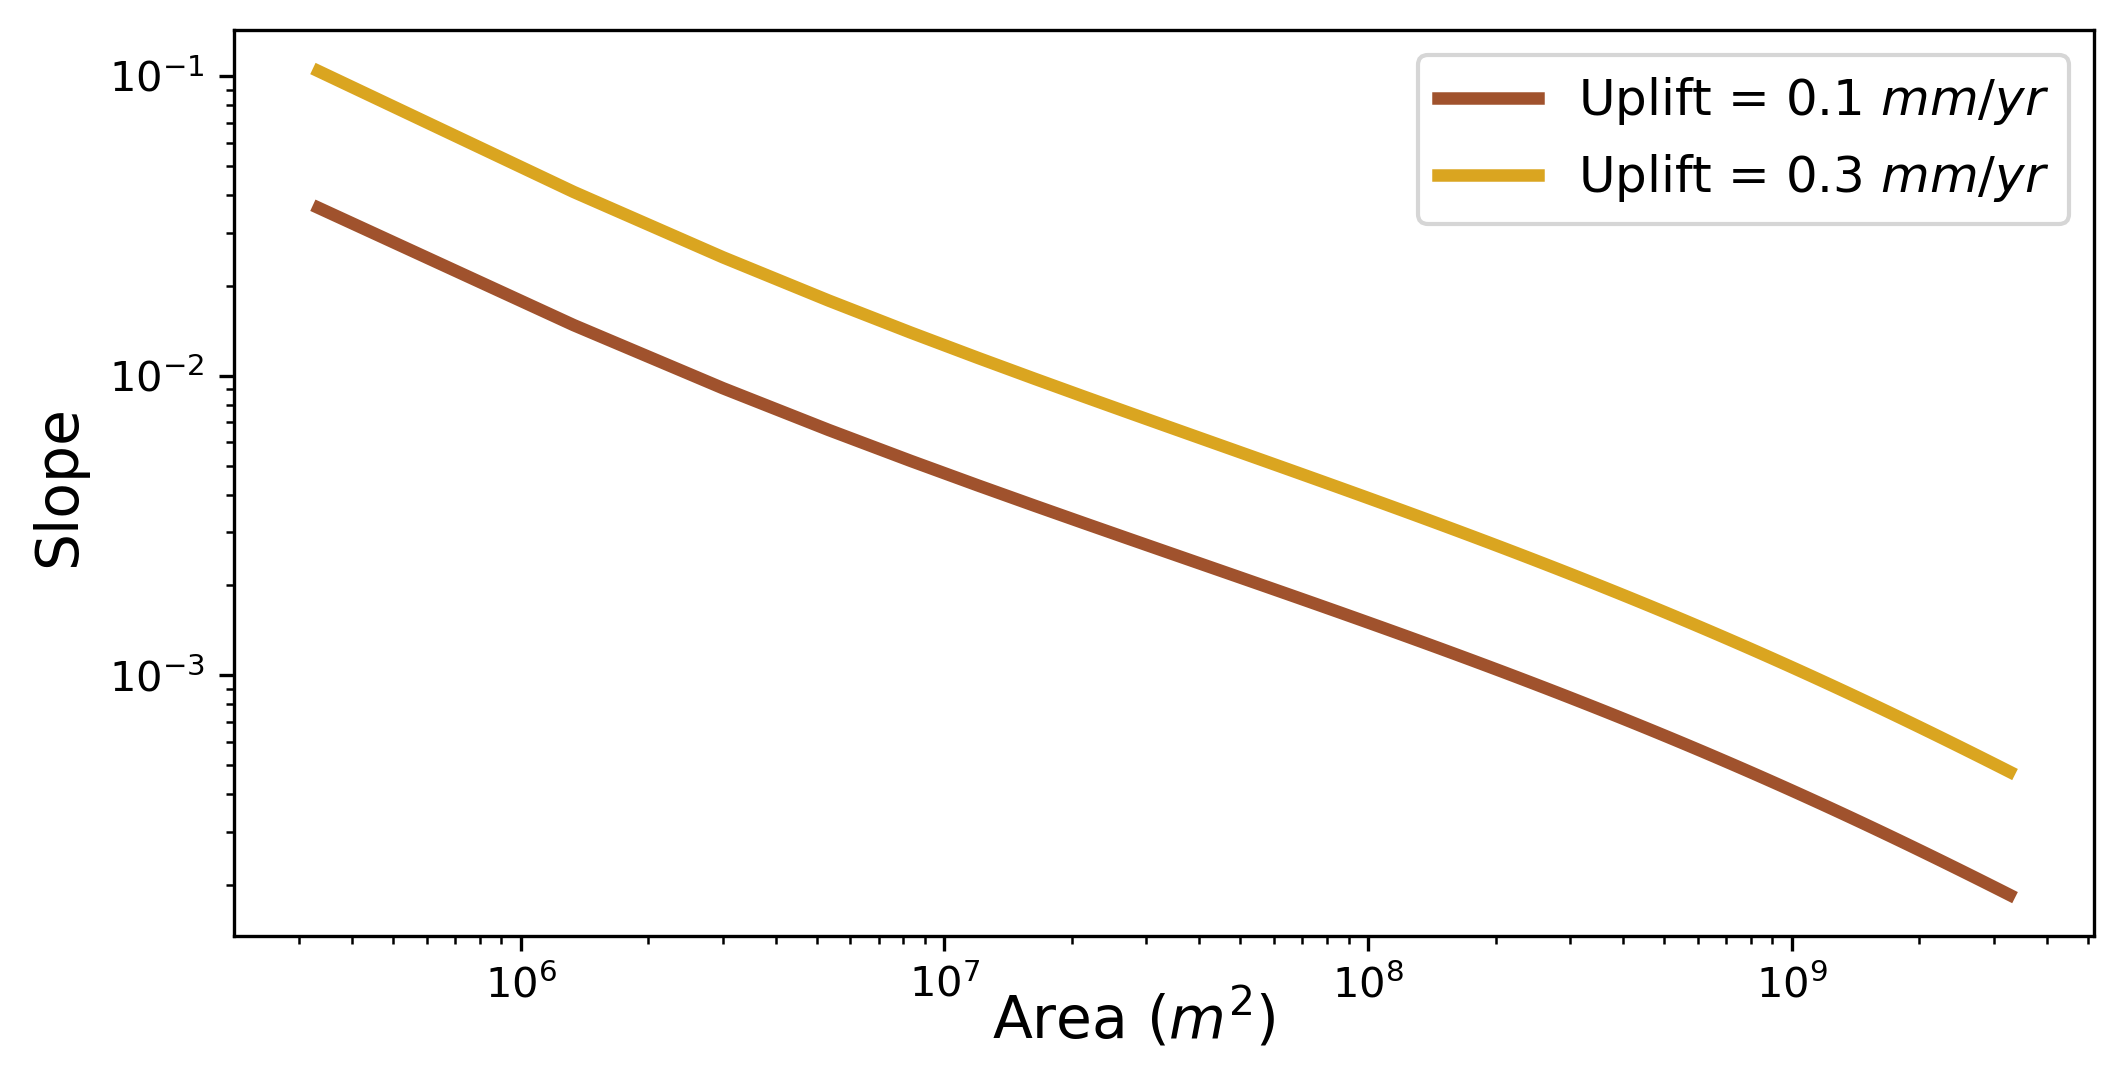

In [21]:
# now compare steepness from different uplift rates
plt.rcParams['figure.dpi'] = 300
# plt.rcParams['savefig.dpi'] = 300

fig, ax = plt.subplots(1, figsize = (8, 4), sharex = True, sharey = True)
fig.text(0.04, 0.5, 'Slope', va='center', rotation='vertical', fontsize = 14)
fig.text(0.5, 0.04, 'Area $(m^2)$', ha='center', fontsize = 14)
# fig.suptitle('Slope-area relationships', fontsize = 16)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.2)

ax.plot(area[1:], S[:], color = 'sienna', linewidth = 3, label = 'Uplift = 0.1 $mm/yr$')
ax.plot(area[1:], S_2[:], color = 'goldenrod', linewidth = 3, label = 'Uplift = 0.3 $mm/yr$')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc = 'best', fontsize = 12)

# ax.plot(area[25:], S[24:], color = 'darkgreen', linewidth = 3)
# ax.plot(area[25:], slope_fit_down, color = 'k',linestyle = ':')
# ax.plot(area[25:], upper_bound_down_slope_fit, color = 'k')
# ax.plot(area[25:], lower_bound_down_slope_fit, color = 'k')
# # ax.fill_between(area[1:25], upper_bound_up_slope_fit, lower_bound_up_slope_fit, color = 'k', alpha = 0.2)
# ax.fill_between(area[25:], upper_bound_down_slope_fit, lower_bound_down_slope_fit, color = 'darkgreen', alpha = 0.2)
# ax.set_yscale('log')
# ax.set_xscale('log')
# # axs[1].set_title('Downstream', fontsize = 16)

plt.savefig('AGU_steepness_plot_single.png')
plt.show()

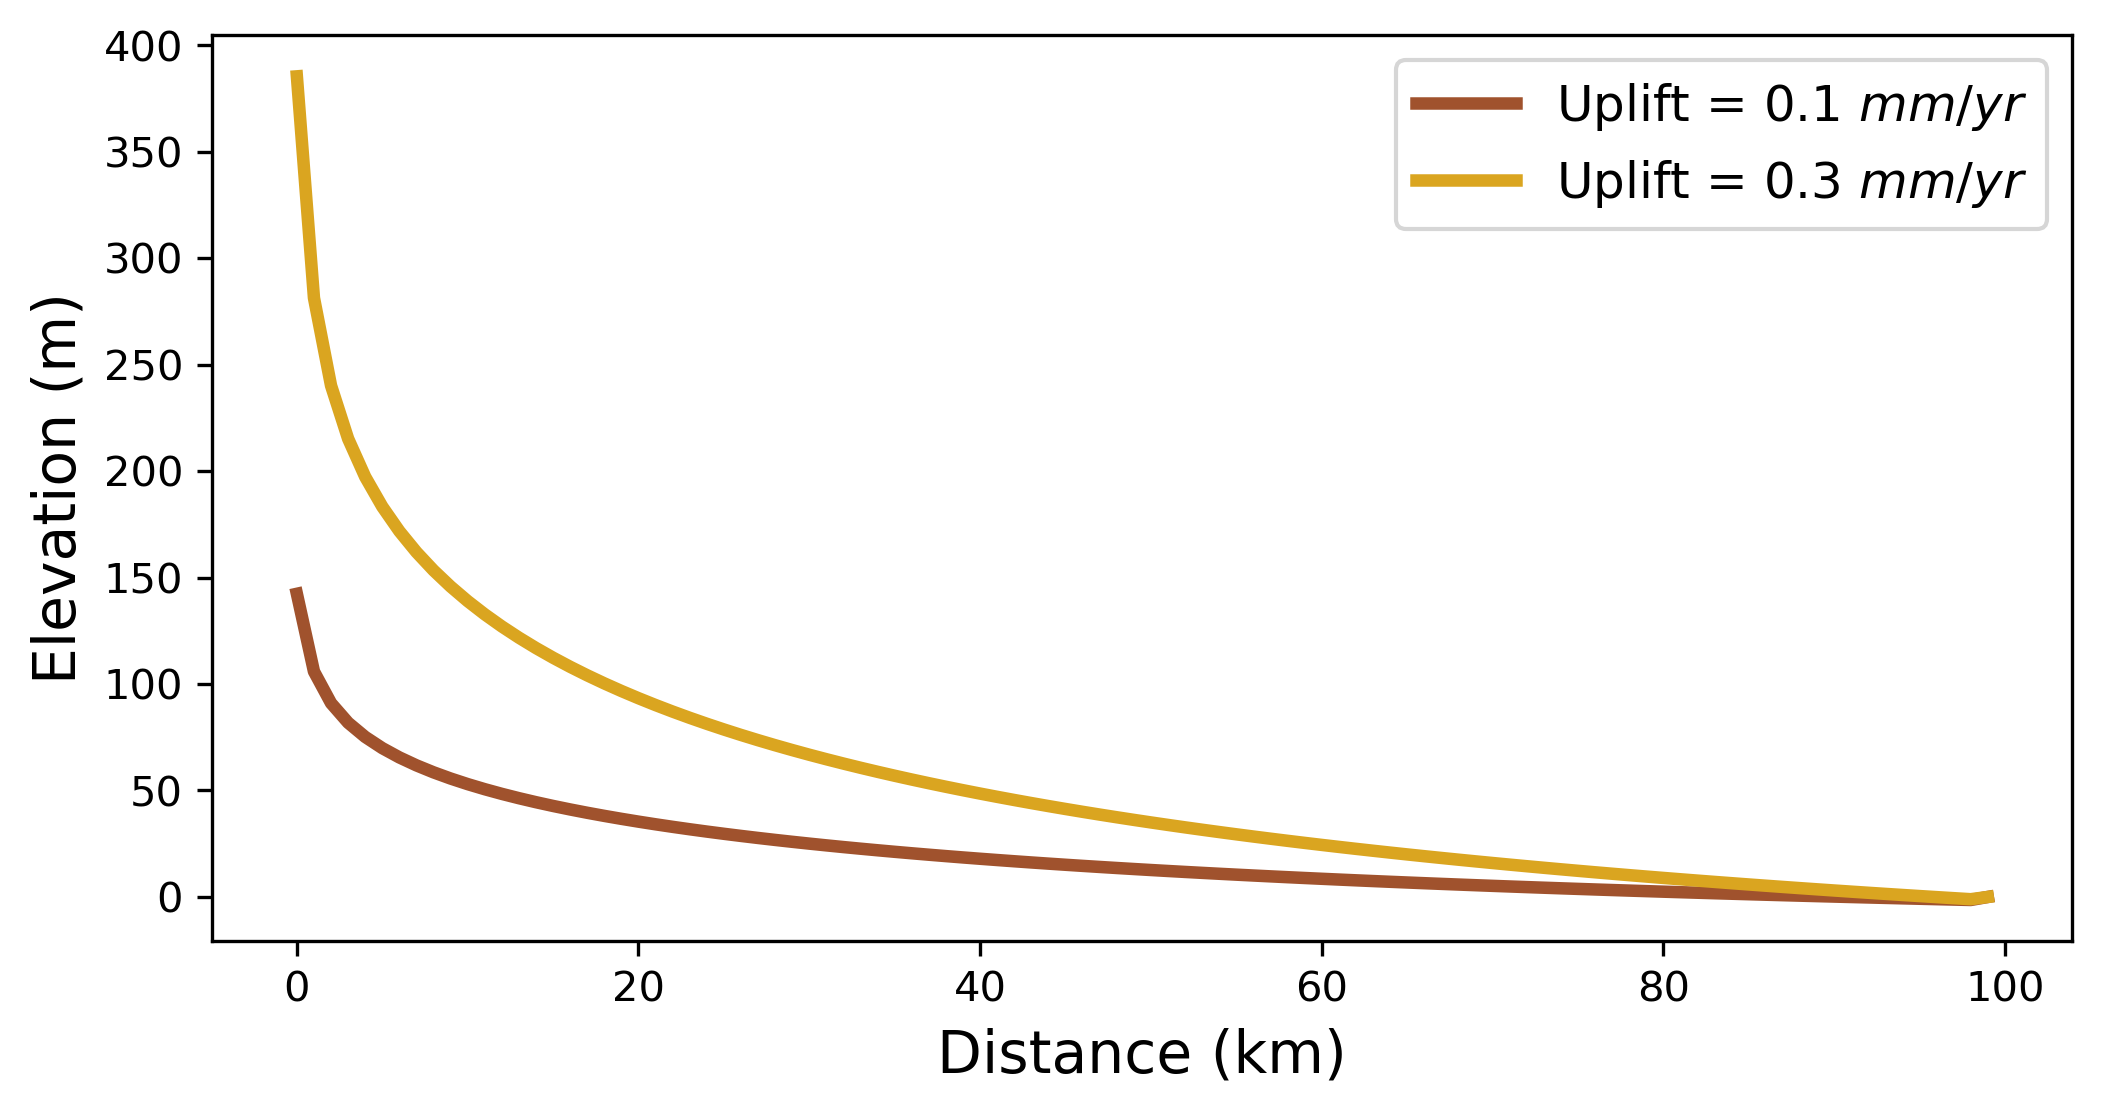

In [23]:
# great, now make a steady state profile figure
plt.rcParams['figure.dpi'] = 300
# plt.rcParams['savefig.dpi'] = 300

fig = plt.figure(figsize = (8, 4))

plt.plot(x/1000, etab - eta[-1], label = 'Uplift = 0.1 $mm/yr$', color = 'sienna', linewidth = 3)
plt.plot(x_2/1000, etab_2 - eta_2[-1], label = 'Uplift = 0.3 $mm/yr$', color = 'goldenrod', linewidth = 3)
plt.xlabel('Distance (km)', fontsize = 14)
plt.ylabel('Elevation (m)', fontsize = 14)
# plt.vlines(x = 24, 
#            ymin = 0, 
#            ymax = 160, 
#            label = 'Bedrock contact', 
#            color = 'k', 
#            linestyle = '--')
# plt.title('Steady state topography', fontsize = 16)
plt.legend(fontsize = 12)

plt.savefig('AGU_concavity_steepness_plot_single.png')
plt.show()